<a href="https://colab.research.google.com/github/spinafex/hyperobjects/blob/main/antifragile_portfolios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

# Parameters
n_bets = 20
initial_capital = 100000
bet_size = initial_capital / n_bets
hit_rate = 0.51
upside = 4  # 4:1 means $1 becomes $5 on success
downside = -1  # Lose 100% of bet on failure
min_duration, max_duration = 3, 6
n_months = 60
n_simulations = 100

# Simulate portfolio
results = []
for sim in range(n_simulations):
    capital = initial_capital
    portfolio = pd.DataFrame({
        'bet_size': [bet_size] * n_bets,
        'duration': np.random.uniform(min_duration, max_duration, n_bets),
        'resolve_time': np.random.uniform(min_duration, max_duration, n_bets)
    })

    capital_history = [capital]

    for month in range(n_months):
        # Check for resolved bets
        resolved = portfolio['resolve_time'] <= month
        if resolved.any():
            # Simulate outcomes for resolved bets
            outcomes = np.random.rand(sum(resolved)) < hit_rate
            returns = np.where(outcomes, upside, downside) * portfolio[resolved]['bet_size']

            # Update capital
            capital += returns.sum()

            # Replace resolved bets
            portfolio.loc[resolved, 'bet_size'] = capital / n_bets
            portfolio.loc[resolved, 'duration'] = np.random.uniform(min_duration, max_duration, sum(resolved))
            portfolio.loc[resolved, 'resolve_time'] = month + portfolio.loc[resolved, 'duration']

        capital_history.append(capital)

    results.append(capital_history)

# Analyze results
results = np.array(results)
mean_final = results[:, -1].mean()
std_final = results[:, -1].std()
cagr = (mean_final / initial_capital) ** (12 / n_months) - 1

print(f"Mean Final Value: ${mean_final:,.2f}")
print(f"Standard Deviation: ${std_final:,.2f}")
print(f"Annualized Return (CAGR): {cagr:.2%}")

Mean Final Value: $933,256,879.86
Standard Deviation: $518,703,360.98
Annualized Return (CAGR): 522.30%


In [5]:
import numpy as np

# Parameters
n_bets = 20
capital = 100
hit_rate = 0.51
upside = 4
downside = -1
duration_min = 3
duration_max = 6
months = 36
n_simulations = 10000

# Simulate one portfolio run
def simulate_portfolio():
    portfolio = capital
    active_bets = [(capital/n_bets, np.random.uniform(duration_min, duration_max)) for _ in range(n_bets)]
    for month in range(months):
        new_bets = []
        for bet in active_bets:
            stake, duration = bet
            if month >= duration:  # Bet resolves
                outcome = np.random.random() < hit_rate
                portfolio += stake * (upside if outcome else downside)
                # Replace with new bet
                new_bets.append((stake, month + np.random.uniform(duration_min, duration_max)))
            else:
                new_bets.append(bet)
        active_bets = new_bets
    return portfolio

# Run simulations
results = [simulate_portfolio() for _ in range(n_simulations)]
print(f"Median final value: ${np.median(results):.2f}")
print(f"5th-95th percentile: ${np.percentile(results, 5):.2f} - ${np.percentile(results, 95):.2f}")

Median final value: $1120.00
5th-95th percentile: $890.00 - $1360.00


Median CAGR: 54.67%
5th Percentile CAGR: 28.06%
95th Percentile CAGR: 75.17%


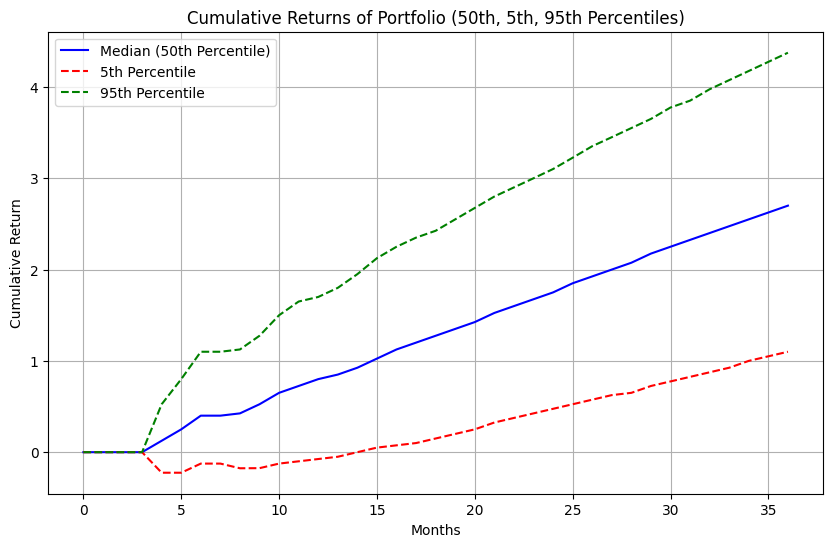

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_bets = 20
initial_capital = 100
hit_rate = 0.40
upside = 2.5
downside = -1
duration_min = 3
duration_max = 6
months = 36
n_simulations = 10000
years = 3

# Simulate one portfolio trajectory and return monthly values
def simulate_portfolio():
    portfolio_value = initial_capital
    monthly_values = [initial_capital]
    active_bets = [(initial_capital/n_bets, np.random.uniform(duration_min, duration_max)) for _ in range(n_bets)]

    for month in range(1, months + 1):
        new_bets = []
        for stake, resolution_time in active_bets:
            if month >= resolution_time:  # Bet resolves
                outcome = np.random.random() < hit_rate
                portfolio_value += stake * (upside if outcome else downside)
                # Replace with new bet
                new_bets.append((initial_capital/n_bets, month + np.random.uniform(duration_min, duration_max)))
            else:
                new_bets.append((stake, resolution_time))
        active_bets = new_bets
        monthly_values.append(portfolio_value)

    return np.array(monthly_values)

# Run simulations
trajectories = np.array([simulate_portfolio() for _ in range(n_simulations)])

# Calculate CAGR
final_values = trajectories[:, -1]
cagr = (final_values / initial_capital) ** (1 / years) - 1

# Compute percentiles
median_cagr = np.median(cagr)
p5_cagr = np.percentile(cagr, 5)
p95_cagr = np.percentile(cagr, 95)

print(f"Median CAGR: {median_cagr:.2%}")
print(f"5th Percentile CAGR: {p5_cagr:.2%}")
print(f"95th Percentile CAGR: {p95_cagr:.2%}")

# Compute cumulative returns for plotting
cumulative_returns = (trajectories / initial_capital) - 1
median_trajectory = np.percentile(cumulative_returns, 50, axis=0)
p5_trajectory = np.percentile(cumulative_returns, 5, axis=0)
p95_trajectory = np.percentile(cumulative_returns, 95, axis=0)

# Plot
plt.figure(figsize=(10, 6))
months_axis = np.arange(0, months + 1)
plt.plot(months_axis, median_trajectory, label="Median (50th Percentile)", color="blue")
plt.plot(months_axis, p5_trajectory, label="5th Percentile", color="red", linestyle="--")
plt.plot(months_axis, p95_trajectory, label="95th Percentile", color="green", linestyle="--")
plt.xlabel("Months")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns of Portfolio (50th, 5th, 95th Percentiles)")
plt.legend()
plt.grid(True)
plt.show()

Allocation: 30% Binary Bets, 70% Safe Asset
Median CAGR: 5.65%
5th Percentile CAGR: -8.88%
95th Percentile CAGR: 17.34%


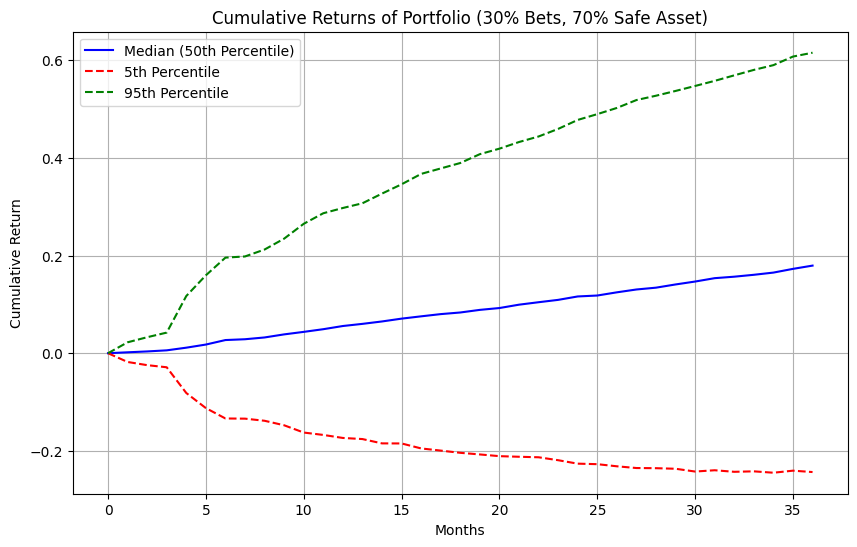

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_bets = 20
initial_capital = 100
hit_rate = 0.35
upside = 2
downside = -1
duration_min = 3
duration_max = 6
bet_correlation = 0.1
months = 36
years = 3
n_simulations = 10000
safe_return = 0.035  # 3.5% annualized return
safe_vol = 0.06      # 6% annualized volatility
w_bets = 0.3         # Allocation to binary bets (70%)
w_safe = 1 - w_bets  # Allocation to safe asset (30%)

# Simulate safe asset trajectory (monthly returns using GBM)
def simulate_safe_asset():
    dt = 1/12  # Monthly time step
    monthly_values = [initial_capital * w_safe]
    for _ in range(months):
        drift = (safe_return - 0.5 * safe_vol**2) * dt
        shock = safe_vol * np.sqrt(dt) * np.random.normal()
        growth = np.exp(drift + shock)
        monthly_values.append(monthly_values[-1] * growth)
    return np.array(monthly_values)

# Simulate binary bets trajectory
def simulate_bets():
    portfolio_value = initial_capital * w_bets
    monthly_values = [portfolio_value]
    active_bets = [(portfolio_value/n_bets, np.random.uniform(duration_min, duration_max)) for _ in range(n_bets)]

    for month in range(1, months + 1):
        new_bets = []
        for stake, resolution_time in active_bets:
            if month >= resolution_time:  # Bet resolves
                outcome = np.random.random() < hit_rate
                portfolio_value += stake * (upside if outcome else downside)
                # Replace with new bet
                new_bets.append((initial_capital * w_bets / n_bets, month + np.random.uniform(duration_min, duration_max)))
            else:
                new_bets.append((stake, resolution_time))
        active_bets = new_bets
        monthly_values.append(portfolio_value)

    return np.array(monthly_values)

# Simulate combined portfolio
def simulate_portfolio():
    bets_values = simulate_bets()
    safe_values = simulate_safe_asset()
    return bets_values + safe_values

# Run simulations
trajectories = np.array([simulate_portfolio() for _ in range(n_simulations)])

# Calculate CAGR
final_values = trajectories[:, -1]
cagr = (final_values / initial_capital) ** (1 / years) - 1

# Compute percentiles
median_cagr = np.median(cagr)
p5_cagr = np.percentile(cagr, 5)
p95_cagr = np.percentile(cagr, 95)

print(f"Allocation: {w_bets*100:.0f}% Binary Bets, {w_safe*100:.0f}% Safe Asset")
print(f"Median CAGR: {median_cagr:.2%}")
print(f"5th Percentile CAGR: {p5_cagr:.2%}")
print(f"95th Percentile CAGR: {p95_cagr:.2%}")

# Compute cumulative returns for plotting
cumulative_returns = (trajectories / initial_capital) - 1
median_trajectory = np.percentile(cumulative_returns, 50, axis=0)
p5_trajectory = np.percentile(cumulative_returns, 5, axis=0)
p95_trajectory = np.percentile(cumulative_returns, 95, axis=0)

# Plot
plt.figure(figsize=(10, 6))
months_axis = np.arange(0, months + 1)
plt.plot(months_axis, median_trajectory, label="Median (50th Percentile)", color="blue")
plt.plot(months_axis, p5_trajectory, label="5th Percentile", color="red", linestyle="--")
plt.plot(months_axis, p95_trajectory, label="95th Percentile", color="green", linestyle="--")
plt.xlabel("Months")
plt.ylabel("Cumulative Return")
plt.title(f"Cumulative Returns of Portfolio ({w_bets*100:.0f}% Bets, {w_safe*100:.0f}% Safe Asset)")
plt.legend()
plt.grid(True)
plt.show()